In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
model_name = ["OPT-1.3B", "Phi-2B", "Yi-6B", "Llama-2\n7B", "Llama-2\n13B", "Llama-3\n8B", "Geo\nMean"]
acc_list   = ["FP16", "BitMoD-LL", "ANT-LY", "OliVe-LY", "BitMoD-LY"]

# "_d" stands for "discriminative"
# "_d" stands for "generative"
# "bitmod_con" means "lossless" BitMoD quantization
# "bitmod_agg" means "lossy" BitMoD quantization

energy_fp16_d       = np.array([[656667, 2549498], [1273252, 6252349], [2614171, 13014774], [2928682, 15511220], [5742951, 36365138], [3279511, 18528840]])
energy_ant_d        = np.array([[459880, 1360903], [888236, 3147508], [1815179, 5659691], [2035862, 7426912], [3981122, 16936053], [2270541, 7910575]])
energy_olive_d      = np.array([[501789, 1308354], [969019, 2969260], [1960581, 5182082], [2192068, 6898215], [4285634, 15557969], [2440769, 7165633]])
energy_bitmod_con_d = np.array([[317887, 1272043], [615118, 3020095], [1255562, 5452484], [1410390, 7186699], [2763255, 16664646], [1572255, 7727074]])
energy_bitmod_agg_d = np.array([[221382, 986623], [428524, 2315439], [871622, 3820005], [981870, 5388371], [1924566, 12460765], [1091548, 5416024]])
energy_discrim      = np.array([energy_fp16_d, energy_bitmod_con_d, energy_ant_d, energy_olive_d, energy_bitmod_agg_d])
efficiency_discrim  = energy_discrim / energy_fp16_d[:, 1:]
efficiency_discrim  = np.concatenate((efficiency_discrim, np.mean(efficiency_discrim, axis=1, keepdims=True)), axis=1)

num_token_generate = 20
energy_fp16_g       = np.array([[25745, 419862], [51929, 847599], [113537, 1854106], [129318, 2113617], [251588, 4110960], [146812, 2399478]])
energy_ant_g        = np.array([[22139, 145879], [44668, 294259], [97934, 669718], [111292, 732882], [216575, 1425302], [125750, 760225]])
energy_olive_g      = np.array([[23250, 119339], [46840, 246787], [104204, 567264], [115455, 582192], [225859, 1133377], [131179, 624942]])
energy_bitmod_con_g = np.array([[15691, 165547], [31662, 334000], [69245, 729367], [78882, 832097], [153502, 1618257], [89561, 943899]])
energy_bitmod_agg_g = np.array([[10470, 86588], [21129, 174535], [46198, 380148], [52631, 434198], [102418, 844271], [59753, 491953]])
energy_generate     = np.array([energy_fp16_g, energy_bitmod_con_g, energy_ant_g, energy_olive_g, energy_bitmod_agg_g])*num_token_generate + energy_discrim
efficiency_generate = energy_generate / (energy_fp16_g[:, 1:]*num_token_generate + energy_fp16_d[:, 1:])
efficiency_generate = np.concatenate((efficiency_generate, np.mean(efficiency_generate, axis=1, keepdims=True)), axis=1)

efficiency = np.array([efficiency_discrim, efficiency_generate])


## Energy Efficiency

In [4]:
linestyle   = 'solid'
alpha       = 1

xlabel_size = 10
xtick_size  = 8.5
ylabel_size = 10.5
ytick_size  = 11.

text_size   = 9.5
legend_size = 10
title_size  = 10.5

# bar setting
width      = 0.02  # the width of each bar
edgewidth  = 0.8    # the edge width of each bar
hatchwidth = 0.5    # the edge width of each bar
spacing    = 0.14   # spacing between each model bar
distance   = 0.008   # spacing between every two bars of the same model

x          = np.arange(len(model_name))*spacing # the label locations

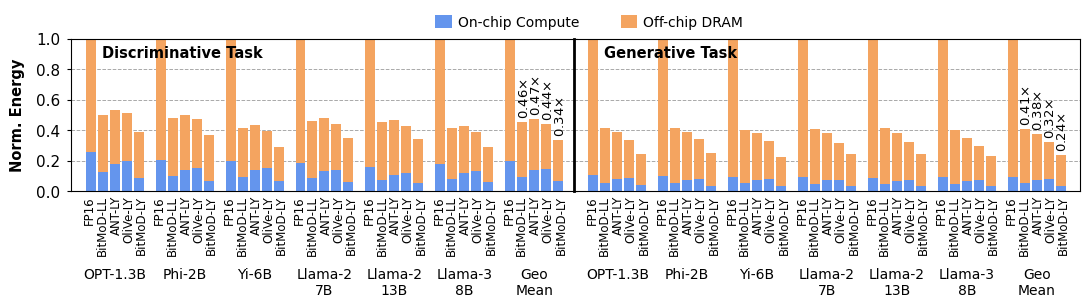

In [5]:
figwidth    = 11
figheight   = 3.8

y_title_pad = 0
y_title_loc = 0.82
rotation = 0
x_margin = 0.03
xlabel_loc = -0.5


############# Draw Figures #############
f, ax = plt.subplots(1, 2)
f.set_figwidth(figwidth)
f.set_figheight(figheight)
f.tight_layout(pad=1)

f_list = [i for i in range(2)]
color_list = ['sandybrown', 'cornflowerblue']
xlabels = model_name

arrow_xloc = x + width + distance/2
ymax = 5

for i in range(2):
    for j_tmp in range(-2, 3):
        j = j_tmp + 2
        f_list[1] = ax[i].bar(x + j_tmp*width + distance*j_tmp/2, efficiency[i, j, :, 1], 
                              width, color=color_list[0])
        f_list[0] = ax[i].bar(x + j_tmp*width + distance*j_tmp/2, efficiency[i, j, :, 0], 
                              width, color=color_list[1])
    
    y_low = 0
    y_up  = 1.001
    ax[i].set_ylim(y_low, y_up)
    ax[i].set_yticks(np.arange(y_low, y_up, 0.2))
    
    x_ticks = np.concatenate((x-2*width-distance*2/2-0.002, x-width-distance/2-0.001, x+0.003, x+width+distance/2+0.004, x+2*width+distance*2/2+0.006))
    x_ticklabels = []
    for acc in acc_list:
        for _ in model_name:
            x_ticklabels.append(acc)
    ax[i].set_xticks(x_ticks)
    ax[i].set_xticklabels(x_ticklabels)
    ax[i].tick_params(axis='x', which='major', labelsize=xtick_size, pad=3, length=0, labelrotation=90)
    
    ax[i].set_xticks(x, minor=True)
    for k, xpos in enumerate(ax[i].get_xticks(minor=True)):
        ax[i].text(xpos, xlabel_loc, model_name[k], size=xlabel_size, ha='center', va='top')
    ax[i].tick_params(axis='x', which='minor', pad=3, length=0)
    
    if i == 0:
        ax[i].tick_params(axis='y', which='major', labelsize=ytick_size, pad=5, length=3)
        
        ax[i].spines['right'].set_visible(False)
        ax[i].set_ylabel('Norm. Energy', weight='bold', fontsize=ylabel_size, labelpad=8)
        
        ax[i].set_title('Discriminative Task', fontsize=title_size, weight='bold', x=0.22, y=y_title_loc)
    if i == 1:        
        ax[i].tick_params(left=False, which='both')
        ax[i].yaxis.set_tick_params(labelleft=False)
        ax[i].spines['left'].set_visible(True)
        ax[i].spines['left'].set_linewidth(2)
        
        ax[i].set_title('Generative Task', fontsize=title_size, weight='bold', x=0.19, y=y_title_loc)
    
    ax[i].margins(x=x_margin)
    ax[i].set_axisbelow(True)
    ax[i].grid(True, linestyle='dashed', axis='y', zorder=1000, color='darkgrey', linewidth=0.7)
    
    ########## Geomean Speedup Annotation ##########
    for j_tmp in range(-1, 3):
        j = j_tmp + 2
        text_x  = (len(model_name) - 1)*spacing + j_tmp*width + distance*j_tmp/2 + 0.004
        text_y  = efficiency[i, j, -1, -1] + 0.02
        txt = ax[i].annotate(text=str(round(efficiency[i, j, -1, -1], 2)) + r'$\times$', xy=(text_x, text_y), fontsize=text_size,
                             horizontalalignment='center', verticalalignment='bottom', rotation=90)
    

leg = f.legend(f_list, ['On-chip Compute', 'Off-chip DRAM'], loc='upper center', bbox_to_anchor=[0.54, 1.04], 
        fontsize=legend_size, ncol=5, columnspacing=3, frameon=False, edgecolor='grey', handlelength=1.2, handleheight=1, handletextpad=0.4)

plt.tight_layout(h_pad=0, w_pad=-0.25)
f.savefig('energy.svg', transparent=True, bbox_inches = 'tight', format='svg', dpi=200, pad_inches=0.1)
